In [1]:
using JLD, Plots
using HDF5
using Base.Iterators
gr()

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


Plots.GRBackend()

In [27]:
arxname="../JLDFiles/Evocada/control1/LFP_Promedio_est_con5.jld"
datos=load(arxname)
csd=datos["kCSDCorrecta"]
freq=datos["freq"]
retr=datos["retrazo"]
lat=datos["latencia"]
cresp=datos["Canalesrespuesta"]
csatu=datos["CanalesSaturados"]

Set(Array{Int64,1}[[11, 63], [29, 55], [7, 46], [14, 15], [23, 19], [55, 35], [15, 43], [31, 46], [1, 1], [44, 23]  …  [6, 37], [56, 51], [13, 22], [37, 14], [9, 33], [13, 45], [10, 38], [9, 43], [13, 20], [54, 55], [1, 12]])

In [28]:
(h,w,nmax)=size(csd)
epsi=21
  ss=[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [29]:
size(csd)

(64, 64, 1163)

In [30]:
keys(datos)

Base.KeySet for a Dict{String,Any} with 10 entries. Keys:
  "Canalesrespuesta"
  "KTT_KInv"
  "freq"
  "latencia"
  "kCSDCorrecta"
  "retrazo"
  "Nota"
  "LFPSaturados"
  "final"
  "CanalesSaturados"

In [31]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [32]:
csdsymb=map(x->simboliza(x), csd);

In [33]:
xs=csdsymb[16,28,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [34]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [35]:
function ncartprod(ss, n)
    argumento=ntuple(i->ss, n)
    result=product(argumento...)
    return(result)
end

ncartprod (generic function with 1 method)

In [36]:
# con permiso de StackOverflow oooo.key takes lot to compile!
issubvec(v,big) = any([v == big[i:(i+length(v)-1)] for i=1:(length(big)-length(v)+1)])

issubvec (generic function with 1 method)

In [37]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        aux=problock(xxs, pr)
        if aux>0
            result[pr]= aux
        else
            push!(malas, pr)
        end
    end
    return (result, malas)
end


function allprobsn(xxs, ss, n, vacias)
    
    #ush tambien muy ineficiente. Sigue siendo mejor buscar a lo pendejo???
            result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        tanteada=any(issubvec(v, pr) for v in vacias)
        if tanteada
         #   print(pr, " esta tanteada!!  ")
            aux=0
        else
            aux=problock(xxs, pr)
            if aux>0
                result[pr]= aux
            else
                push!(malas, pr)
            end
        end # sobre tanteada
    end #sobre palabras
    return (result, malas)
end

allprobsn (generic function with 2 methods)

Haciendo pruebas, al parecer matar el conjunto de malas con entre 3 y 4 letras es la forma más rapida. Ya despues de eso tiene que revisar palabrerias tan largas que no conviene.

In [38]:
@time (p, v3)=allprobsn(xs, ss, 3)

  0.173611 seconds (205.84 k allocations: 11.991 MiB, 59.75% gc time)


(Dict{Array,Float64}([-1, -1, 0]=>0.000861326,[0, -1, -1]=>0.000861326,[0, 0, 0]=>0.953488,[0, -1, 0]=>0.00172265,[-1, 0, 0]=>0.00258398,[1, 0, 0]=>0.000861326,[0, 0, -1]=>0.00258398,[-1, -1, -1]=>0.0353144,[0, 0, 1]=>0.000861326,[0, 1, 0]=>0.000861326…), Set(Any[[1, -1, -1], [-1, 1, 1], [-1, 1, 0], [-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, -1, 1], [1, 1, 1], [1, -1, 0], [0, 1, -1], [-1, 0, 1], [1, -1, 1], [1, 1, -1], [1, 1, 0], [0, -1, 1], [-1, 1, -1], [0, 1, 1]]))

In [39]:
@time (p, v)=allprobsn(xs, ss, 11)

 31.119095 seconds (205.60 M allocations: 33.628 GiB, 45.59% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1]=>0.000867303,[-1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.000867303,[-1, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]=>0.000867303,[0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1]=>0.000867303,[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]=>0.028621,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000867303,[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.00173461…), Set(Any[[-1, -1, -1, -1, -1, -1, -1, 1, 0, 1, -1], [1, -1, 0, -1, 1, -1, 1, -1, 1, 0, 0], [-1, 0, -1, 0, 0, 0, -1, 0, -1, 1, 0], [1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1], [1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [-1, -1, 0, 0, -1, -1, -1, 0, 1, 1, -1], [-1, 0, 0, -1, -1, -1, 1, 0, 1, 1, 0], [1, -1, 0, 1, 1, 0, 1, 1, 1, 0, -1], [-1, -1, -1, 0, 1, 0, 0, 1, 1, 1, 0], [-1, 1, -1, 0, 1, 1, -1, 0, 0, 0, 1]  …  [1, 0, -1, 0, 0, 1, 0, 0, -1, -1, -1], [0, 1, 1, -1, -1, 0, 1, -1, -1, -1, -1

In [40]:
length(v3)

17

In [41]:
@time (ar, ir)=allprobsn(xs, ss,11, v3)

  1.076222 seconds (10.03 M allocations: 1.071 GiB, 30.01% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1]=>0.000867303,[-1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.000867303,[-1, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]=>0.000867303,[0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1]=>0.000867303,[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]=>0.028621,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000867303,[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.00173461…), Set(Any[[0, 0, 0, -1, -1, -1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0], [-1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 1], [0, -1, 0, 0, 0, 1, 0, 0, 0, -1, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, -1, 0, 0, 1, 0, 0, -1, -1], [0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0], [-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, -1, 0, 0, -1, -1, 0, 0, -1, -1, -1]  …  [0, 1, 0, 0, 0, -1, -1, 0, 0, -1, -1], [-1, -1, -1, -1, 0, 0, -1, -1, -1, 0, 0], [0, 0, 0, -

In [23]:
function shanonH_n(xxs, ss, n)
    (probs, v)=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(xxs, ss, n, v)
    (probs, v)=allprobsn(xxs,ss,n, v)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(probs,n)
    #meter un dict con probs>0 porfis
    h=0
    for q in values(probs)
        h+=q*log(q)
    end
    result=-h/n
    return result
end

shanonH_n (generic function with 3 methods)

In [42]:
struct hazfibrado
    renglon::Int
    columna::Int
    valores::Array{Float64, 1}
end

In [44]:
lmax=length(cresp)

359

In [46]:
log(3, nmax)

6.425158561694472

In [47]:
hhsn=Dict{Array{Int, 1}, Array{Float64,1}}()
hhsn2=Dict{Array{Int, 1}, Array{Float64,1}}()
arbol=Dict{Array{Int,1}, Dict{Int, Array}}()
nn=7
@time for c in cresp
        reng=c[1]
        col=c[2]
        xs=csdsymb[reng,col,:]
        hhsn[c]=zeros(nn)
        arbol[c]=Dict{Int, Array}()
    for n=1:nn
            v=Set()
        if n<4
            probs, v= allprobsn(xs, ss,n)
        else
            probs, v2= allprobsn(xs, ss,n, v)
        end
            buenas=collect(keys(probs))
            arbol[[reng, col]][n]=buenas
        hhsn[[reng,col]][n]=shanonH_n(probs,n)
            
    end

    
end


124.883879 seconds (1.37 G allocations: 175.880 GiB, 34.42% gc time)


In [170]:
sum3n(n)=Int32(3/2*(-1+3^n))

sum3n (generic function with 1 method)

In [171]:
nredu=4
nodosmax=sum3n(nredu)
adja=zeros(Int8,nodosmax,nodosmax);

In [161]:
function trescodifica(xxs)
    #Convierte tus strings raros en un entero como si fuera ternario
    # con las cifras 0,1,2 (que son las que tienes +1)
    ll=length(xxs)
    r=0
    for j=1:ll
       a=xxs[j]+1
       r+=3^(ll-j)*a
    end
    return r
end

trescodifica (generic function with 1 method)

In [173]:
function codanumero(xxs)
    ll=length(xxs)
    naux=sum3n(ll-1)
    bla=trescodifica(xxs)
    r=bla+naux
    return r
end

codanumero (generic function with 1 method)

In [174]:
codanumero(bl)

136

In [162]:
bl=[-1,-1,0,1,0]

5-element Array{Int64,1}:
 -1
 -1
  0
  1
  0

In [163]:
1+6+9

16

In [164]:
trescodifica(bl)

16

In [136]:
arbol[[23,43]][3]

16-element Array{Array,1}:
 [1, -1, -1] 
 [0, -1, -1] 
 [-1, -1, 0] 
 [0, 0, 0]   
 [-1, 0, -1] 
 [1, 1, 1]   
 [0, 1, 0]   
 [-1, 0, 1]  
 [0, -1, 0]  
 [1, 0, 0]   
 [0, 0, 1]   
 [1, 1, -1]  
 [-1, 0, 0]  
 [0, 0, -1]  
 [0, 1, 1]   
 [-1, -1, -1]

In [76]:
arbol=Dict{Array{Int,1}, Dict{Int, Set}}()


Dict{Array{Int64,1},Dict{Int64,Set}} with 0 entries

In [52]:
pp=plot(key=false)
b=1:nn
for k in keys(hhsn)
    y=hhsn[k]
    scatter!(pp, b, y)
end

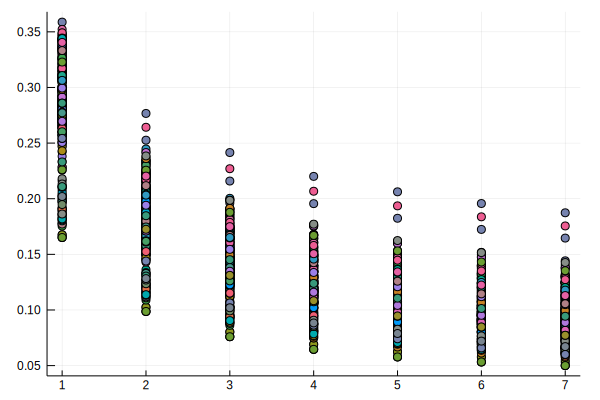

In [53]:
pp

In [ ]:
add

In [54]:
xxx=[]
yyy=[]
gord1=[]
gord2=[]
for k in keys(hhsn)
    push!(xxx, k[2])
    push!(yyy, k[1])
    push!(gord1, hhsn[k][1])
    push!(gord2, hhsn[k][end])
end
    

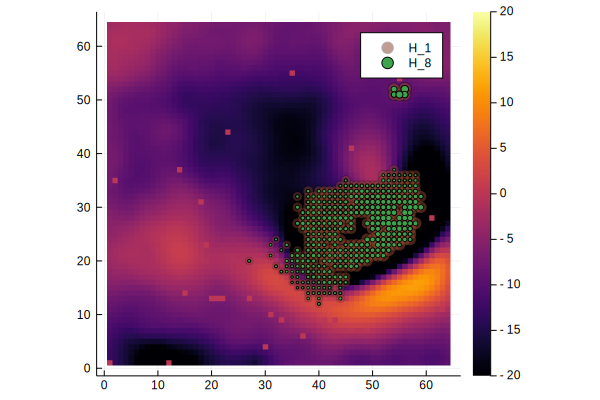

In [66]:
ppp=heatmap(csd[:,:,160], aspect_ratio=1, clims=(-20,20))
scatter!(xxx, yyy, markersize=gord1.*20, label="H_1", markeralpha=gord1)
scatter!(xxx, yyy, markersize=gord2.*20, label="H_8")


In [64]:
retr+lat

117

In [127]:
n=7
A =Int8[ rand() < 0.5 ? 0 : 1 for i=1:n, j=1:n]
for i=1:n
    A[i, 1:i-1] = A[1:i-1, i]
    A[i,i]=0
    A[i,7]=0
    A[7,i]=0
end
#A=A+A'


In [128]:
A

7×7 Array{Int8,2}:
 0  0  0  0  0  1  0
 0  0  1  1  1  0  0
 0  1  0  1  0  0  0
 0  1  1  0  1  0  0
 0  1  0  1  0  0  0
 1  0  0  0  0  0  0
 0  0  0  0  0  0  0

In [112]:
using GraphRecipes

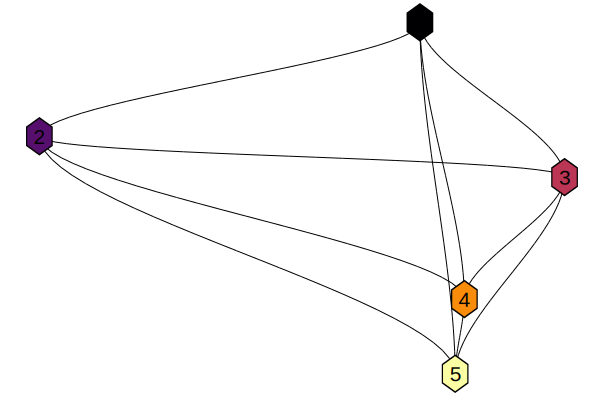

In [114]:
graphplot(A,
       #   node_weights = 1:n,
        #  marker = (:YlOrRd, :rect),
     method=:tree,
          marker_z = 1:n,
          markersize = 3,
          names = 1:n,
          linecolor = :black
)
    


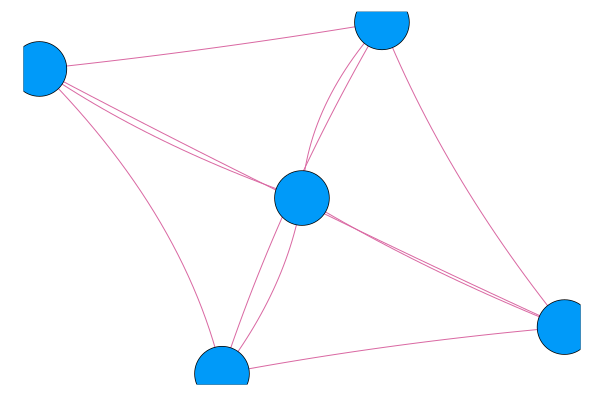

In [92]:
graphplot(A)

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1192


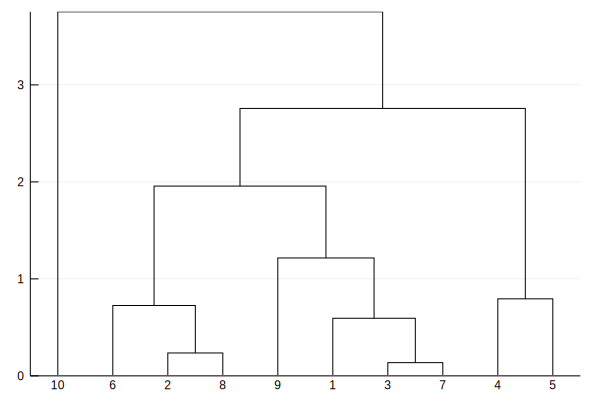

In [97]:
using StatsPlots
using Clustering
D = rand(10, 10)
D += D'
hc = hclust(D, linkage=:single)
plot(hc)

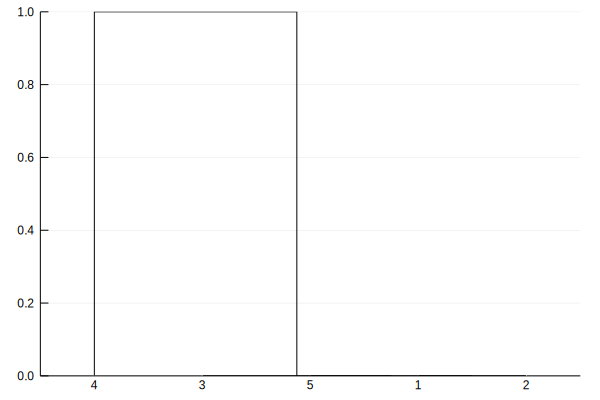

In [99]:
hc = hclust(A, linkage=:single)
plot(hc)

In [115]:
using GraphPlot

┌ Info: Precompiling GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1192


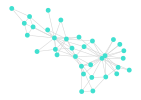

In [116]:
g = graphfamous("karate")
gplot(g)


In [119]:
using LightGraphs

In [129]:
arg=Graph(A)

{7, 6} undirected simple Int64 graph

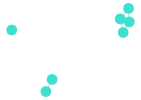

In [130]:
gplot(arg)

In [124]:
A

5×5 Array{Int8,2}:
 0  1  1  1  1
 1  0  0  0  0
 1  0  0  1  1
 1  0  1  0  0
 1  0  1  0  0

In [56]:
max1=maximum(aar)
max8=maximum(bbr)

0.33574732277564123

In [59]:
for k in keys(hhsn)
    if hhsn[k][1]==min1
        print(k, " es el min de 1 bloque. ")
    elseif hhsn[k][1]==max1
        print(k, " es el max de 1 bloque. ")
    end
   if hhsn[k][8]==min8
        print(k, " es el min de 8 bloque. ")
    elseif hhsn[k][8]==max8
        print(k, " es el max de 8 bloque. ")
    end
end


[36, 54] es el max de 1 bloque. [24, 61] es el max de 8 bloque. [42, 51] es el min de 1 bloque. [42, 51] es el min de 8 bloque. 

In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [ ]:
allprobsn(xs, ss, 3)

In [ ]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

In [102]:
struct ONodo
    mesmo
end
a=ONodo(1)

ONodo(1)

In [101]:
?Nodo

search: Nodo unicodeplots UndefKeywordError ncodeunits QuoteNode invmod download



No documentation found.

# Summary

```
struct Nodo <: Any
```

# Fields

```
parent   :: Nodo
children :: Array{Nodo,1}
```


In [98]:
struct fobar
    fo
    bar
end

In [99]:
a=fobar(1,2)

fobar(1, 2)

In [46]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

(0.016129032258064516, 0.9556451612903226, 0.028225806451612902)

In [ ]:
heatmap(sumsym, aspect_ratio=1)

In [ ]:
?heatmap

In [68]:
a=[0,1]
n=[0, 1]
z=[1,1,0]
z2=[1,0,1]

3-element Array{Int64,1}:
 1
 0
 1

In [71]:
@time issubvec(a, z2)

  0.000008 seconds (9 allocations: 512 bytes)


true

In [72]:
@inbounds

LoadError: MethodError: no method matching @inbounds(::LineNumberNode, ::Module)
Closest candidates are:
  @inbounds(::LineNumberNode, ::Module, !Matched::Any) at essentials.jl:538

In [60]:
as=string(a)

"[0, 1]"